In [3]:
import sys
from pathlib import Path

# Add repo root to sys.path FIRST so local trace package takes precedence
repo_root = Path("/Users/rjm707/Desktop/trace_paper")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Now import from local trace package
from trace.statistics import logit, inv_logit
import polars as pl

df = pl.read_csv("../data/semaglutide-atc_table.csv").with_columns(
    group=pl.col("outcome").str.head(1)
).sort("outcome").filter(
    pl.col("outcome") != "A10BJ"
).filter(
    pl.col("group") != "V"
)

In [4]:
filtered = df.with_columns(
    ATC3=pl.col("outcome").str.slice(0, 3)
)#.filter(pl.col("treated_prevalence") > 0.01)

In [24]:
pvals = pl.read_csv('../data/semaglutide-atc/combined_results_log_rr_bh.csv', columns=['method', 'outcome', 'q_value']).filter(
    pl.col("method") == "IPW"
)
len(pvals), len(pvals.filter(pl.col("q_value") < 0.05)), len(pvals.filter(pl.col("q_value") < 0.01)), len(pvals.filter(pl.col("q_value") < 0.001))

(328, 237, 214, 178)

In [ ]:
import numpy as np

significance = pvals["q_value"]
values = filtered["log_RR"].to_numpy()
bins = np.digitize(significance, [0.05, 0.01, 0.001])

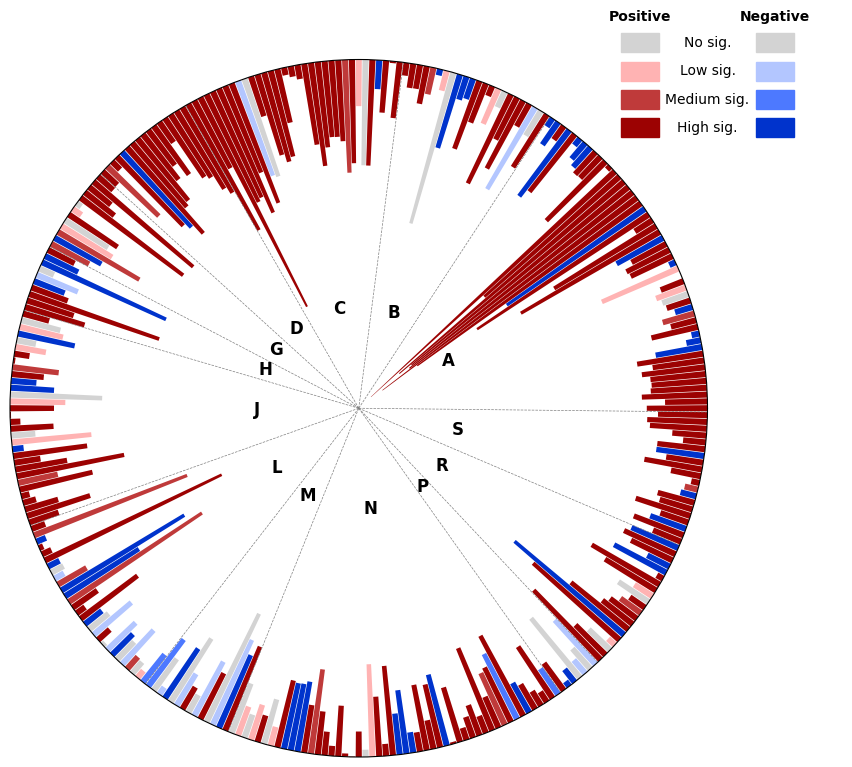

In [21]:
import matplotlib.pyplot as plt
import numpy as np

theta = np.linspace(0, 2*np.pi, len(filtered), endpoint=False)

fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

groups = filtered['group'].unique(maintain_order=True).to_list()

# Define discrete shades
reds = ['#ffb3b3', "#bf3a3a", "#9c0202"]   # light, mid, dark
blues = ['#b3c6ff', '#4d79ff', '#0033cc']

# Bin significance into 3 categories
bins = np.digitize(significance, [0.5, 0.2])

colors_list = []
for val, b in zip(values, bins):
    if b == 0:
        colors_list.append("lightgrey")  # neutral color for low significance
    if val > 0:
        colors_list.append(reds[b])
    else:
        colors_list.append(blues[b])

width = (2 * np.pi / len(filtered)) * 0.9
ax.bar(
    theta, -abs(filtered["log_RR"]), 
    bottom=1, width=width, 
    color=colors_list,
)

# for group in filtered['group'].unique(maintain_order=True):
for group in groups:
    group_rows = filtered.with_row_index().filter(pl.col('group') == group)
    # if len(atc3_rows) <= 1:
    #     continue
    idx = int(group_rows["index"].mean())
    mid_theta = theta[idx]
    ax.text(
        mid_theta, -1.2, group,
        ha="center", va='center',
        rotation_mode='anchor',
        fontsize=12,
        fontweight='bold',
    )

ax.set_rgrids([])  # only show gridlines from radius 1 onwards
ax.set_thetagrids([])

for idx in filtered['group'].value_counts().sort("group")["count"].cum_sum().to_list():
    ax.axvline(theta[idx-1]+width/2, color="gray", lw=0.5, ls="--", clip_on=False, ymax=1)
ax.grid(False)



# --- Create inset axes for custom legend table ---
legend_ax = fig.add_axes([0.75, 0.65, 0.3, 0.15])  # [x0, y0, width, height]
legend_ax.axis('off')
labels = ['No sig.', 'Low sig.', 'Medium sig.', 'High sig.']

# Column headers
legend_ax.text(0.25, 1.0, 'Positive', ha='center', va='bottom', fontweight='bold')
legend_ax.text(0.75, 1.0, 'Negative', ha='center', va='bottom', fontweight='bold')

reds = ['lightgrey'] + reds
blues = ['lightgrey'] + blues

# Draw the colored squares and row labels
for i, (r, b, lab) in enumerate(zip(reds, blues, labels)):
    y = 0.85 - i * 0.15
    # color patches
    legend_ax.add_patch(plt.Rectangle((0.18, y), 0.14, 0.1, color=r, transform=legend_ax.transAxes, clip_on=False))
    legend_ax.add_patch(plt.Rectangle((0.68, y), 0.14, 0.1, color=b, transform=legend_ax.transAxes, clip_on=False))
    # significance labels centered between columns
    legend_ax.text(0.5, y + 0.05, lab, ha='center', va='center')

plt.show()

/var/folders/t8/0k1yc0g54t5c5g_kn7tj10mw0000gn/T/ipykernel_18625/336202019.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


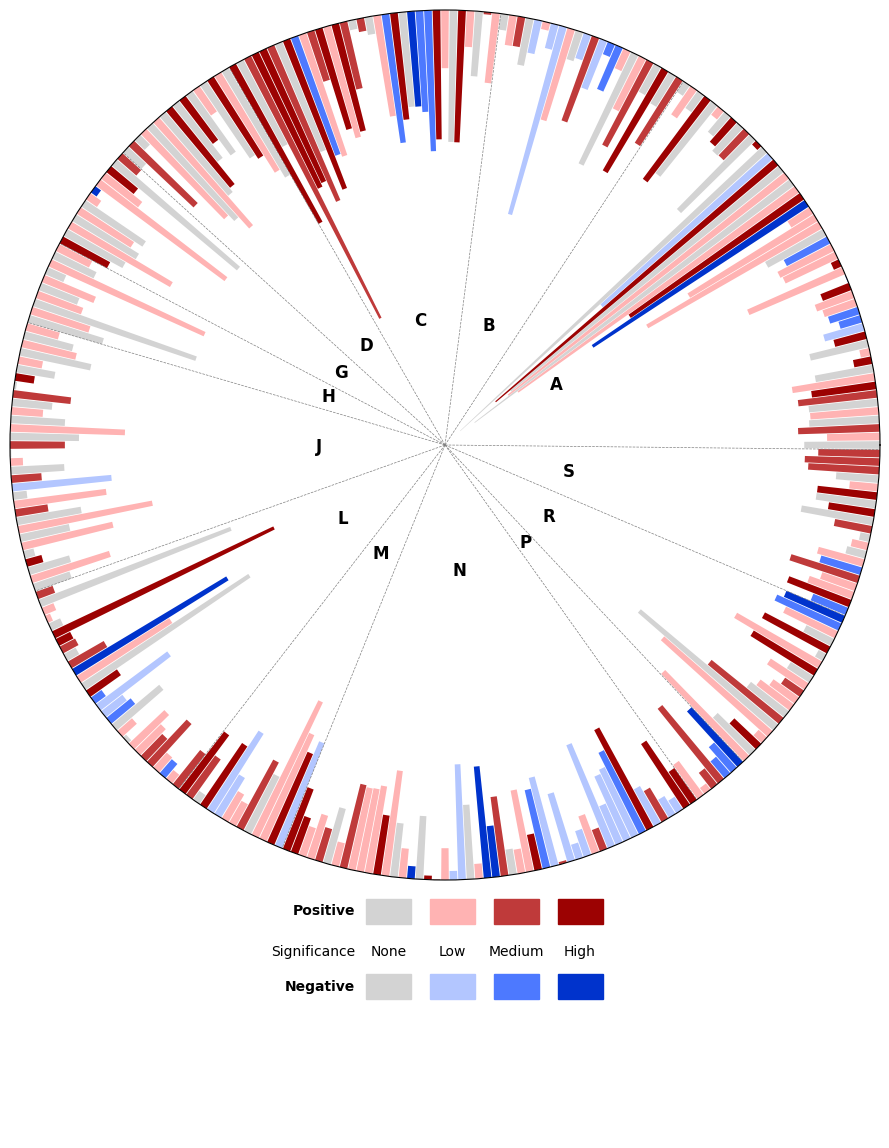

In [91]:
import matplotlib.pyplot as plt
import numpy as np

theta = np.linspace(0, 2*np.pi, len(filtered), endpoint=False)

fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

groups = filtered['group'].unique(maintain_order=True).to_list()

# Define discrete shades
reds = ['#ffb3b3', "#bf3a3a", "#9c0202"]   # light, mid, dark
blues = ['#b3c6ff', '#4d79ff', '#0033cc']

# Bin significance into 3 categories
bins = np.digitize(significance, [0.5, 0.25])

colors_list = []
for val, b in zip(values, bins):
    if val > 0.5:
        colors_list.append("lightgrey")  # neutral color for low significance
    if val > 0:
        colors_list.append(reds[b])
    else:
        colors_list.append(blues[b])

width = (2 * np.pi / len(filtered)) * 0.9
ax.bar(
    theta, -abs(filtered["log_RR"]), 
    bottom=1, width=width, 
    color=colors_list,
)

# for group in filtered['group'].unique(maintain_order=True):
for group in groups:
    group_rows = filtered.with_row_index().filter(pl.col('group') == group)
    # if len(atc3_rows) <= 1:
    #     continue
    idx = int(group_rows["index"].mean())
    mid_theta = theta[idx]
    ax.text(
        mid_theta, -1.2, group,
        ha="center", va='center',
        rotation_mode='anchor',
        fontsize=12,
        fontweight='bold',
    )

ax.set_rgrids([])  # only show gridlines from radius 1 onwards
ax.set_thetagrids([])

for idx in filtered['group'].value_counts().sort("group")["count"].cum_sum().to_list():
    ax.axvline(theta[idx-1]+width/2, color="gray", lw=0.5, ls="--", clip_on=False, ymax=1)
ax.grid(False)



# --- Create inset axes for custom horizontal legend ---
legend_ax = fig.add_axes([0.4, -0.05, 0.5, 0.2])  # [x0, y0, width, height]
legend_ax.axis('off')

labels = ['None', 'Low', 'Medium', 'High']

# Add grey (no sig.) as first level
reds  = ['lightgrey'] + reds
blues = ['lightgrey'] + blues

# Row headers
legend_ax.text(0, 0.9, 'Positive', ha='right', va='center', fontweight='bold')
legend_ax.text(0, 0.71, 'Significance', ha='right', va='bottom')
legend_ax.text(0, 0.6, 'Negative', ha='right', va='center', fontweight='bold')

# Draw colored squares and significance labels
x_positions = np.linspace(0.075, 0.5, len(labels))  # evenly spaced columns
for x, lab, r, b in zip(x_positions, labels, reds, blues):
    # top row (positive)
    legend_ax.add_patch(plt.Rectangle((x - 0.05, 0.85), 0.1, 0.1,
                                      color=r, transform=legend_ax.transAxes, clip_on=False))
    # bottom row (negative)
    legend_ax.add_patch(plt.Rectangle((x - 0.05, 0.55), 0.1, 0.1,
                                      color=b, transform=legend_ax.transAxes, clip_on=False))
    # shared significance label below each column
    legend_ax.text(x, 0.71, lab, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# for atc3 in filtered['ATC3'].unique(maintain_order=True):
#     atc3_rows = filtered.with_row_index().filter(pl.col('ATC3') == atc3)
#     # if len(atc3_rows) <= 1:
#     #     continue
#     idx = int(atc3_rows["index"].mean())
#     mid_theta = theta[idx]
#     angle = np.degrees(mid_theta)

#     # Flip text on the left side
#     if np.pi/2 < mid_theta < 3*np.pi/2:
#         angle += 180
#     ax.text(
#         mid_theta, 1.3, atc3,
#         ha="center", va='center',
#         rotation=angle,
#         rotation_mode='anchor',
#         fontsize=10,
#         fontweight='bold',
#     )